# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore") 

2024-07-31 17:13:11.758100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:13:11.758248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:13:11.914461: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Constant

In [2]:
DATASET_PATH = '/kaggle/input/heart-failure-prediction/heart.csv'

# Utils

In [3]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Step1: Loading & Transforming the Dataset

In [4]:
df = pd.read_csv(DATASET_PATH)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
# Convert categorical columns to numerical using one-hot encoding
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    int64  
 1   RestingBP          918 non-null    int64  
 2   Cholesterol        918 non-null    int64  
 3   FastingBS          918 non-null    int64  
 4   MaxHR              918 non-null    int64  
 5   Oldpeak            918 non-null    float64
 6   HeartDisease       918 non-null    int64  
 7   Sex_F              918 non-null    bool   
 8   Sex_M              918 non-null    bool   
 9   ChestPainType_ASY  918 non-null    bool   
 10  ChestPainType_ATA  918 non-null    bool   
 11  ChestPainType_NAP  918 non-null    bool   
 12  ChestPainType_TA   918 non-null    bool   
 13  RestingECG_LVH     918 non-null    bool   
 14  RestingECG_Normal  918 non-null    bool   
 15  RestingECG_ST      918 non-null    bool   
 16  ExerciseAngina_N   918 non

# Step 2: Exploratory Data Analysis

### Age Distribution
This histogram shows the distribution of ages in the dataset. It helps to understand the age range of the patients and identify any age-related patterns.

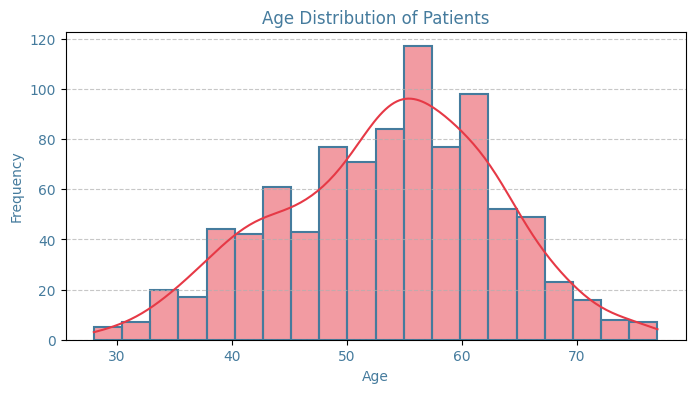

In [7]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Age'], bins=20, kde=True, color='#e63946', edgecolor='#457b9d', linewidth=1.5)
plt.title('Age Distribution of Patients', color='#457b9d')
plt.xlabel('Age', color='#457b9d')
plt.ylabel('Frequency', color='#457b9d')
plt.xticks(color='#457b9d')
plt.yticks(color='#457b9d')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Chest Pain Type Distribution

This bar chart shows the count of different chest pain types experienced by patients. It helps to identify the most common types of chest pain and their potential association with heart disease.


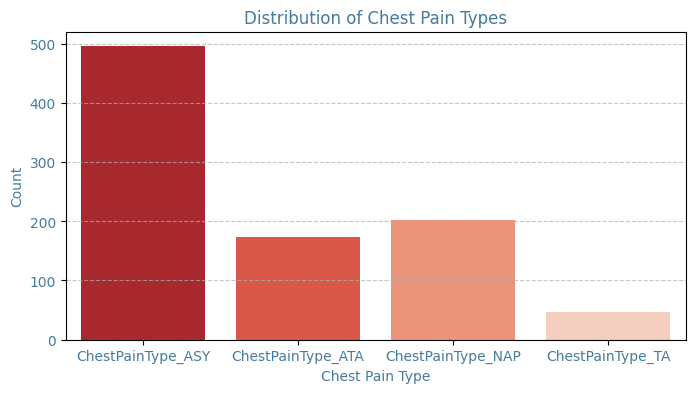

In [8]:
plt.figure(figsize=(8, 4))
chest_pain_counts = df[['ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA']].sum()
sns.barplot(x=chest_pain_counts.index, y=chest_pain_counts.values, palette='Reds_r')
plt.title('Distribution of Chest Pain Types', color='#457b9d')
plt.xlabel('Chest Pain Type', color='#457b9d')
plt.ylabel('Count', color='#457b9d')
plt.xticks(color='#457b9d')
plt.yticks(color='#457b9d')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### MaxHR Distribution

This histogram shows the distribution of maximum heart rates achieved by patients. It helps to understand the range and common values of MaxHR in the dataset.

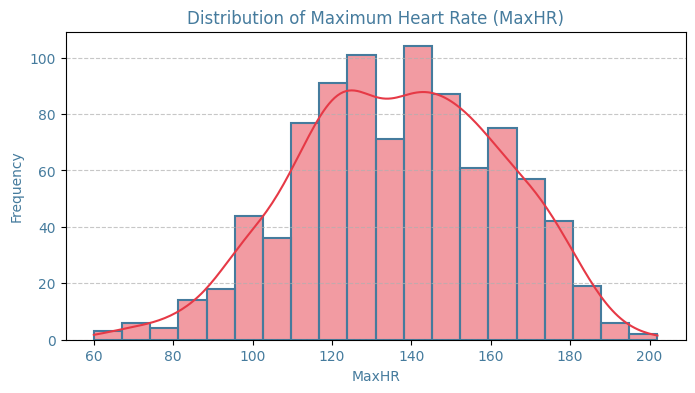

In [9]:
plt.figure(figsize=(8, 4))
sns.histplot(df['MaxHR'], bins=20, kde=True, color='#e63946', edgecolor='#457b9d', linewidth=1.5)
plt.title('Distribution of Maximum Heart Rate (MaxHR)', color='#457b9d')
plt.xlabel('MaxHR', color='#457b9d')
plt.ylabel('Frequency', color='#457b9d')
plt.xticks(color='#457b9d')
plt.yticks(color='#457b9d')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Box Plots for Age, RestingBP, Cholesterol, MaxHR, and Oldpeak by Heart Disease Outcome

These box plots compare the distributions of age, resting blood pressure, cholesterol, maximum heart rate, and oldpeak between patients with and without heart disease. They help to identify any significant differences in these features between the two groups.


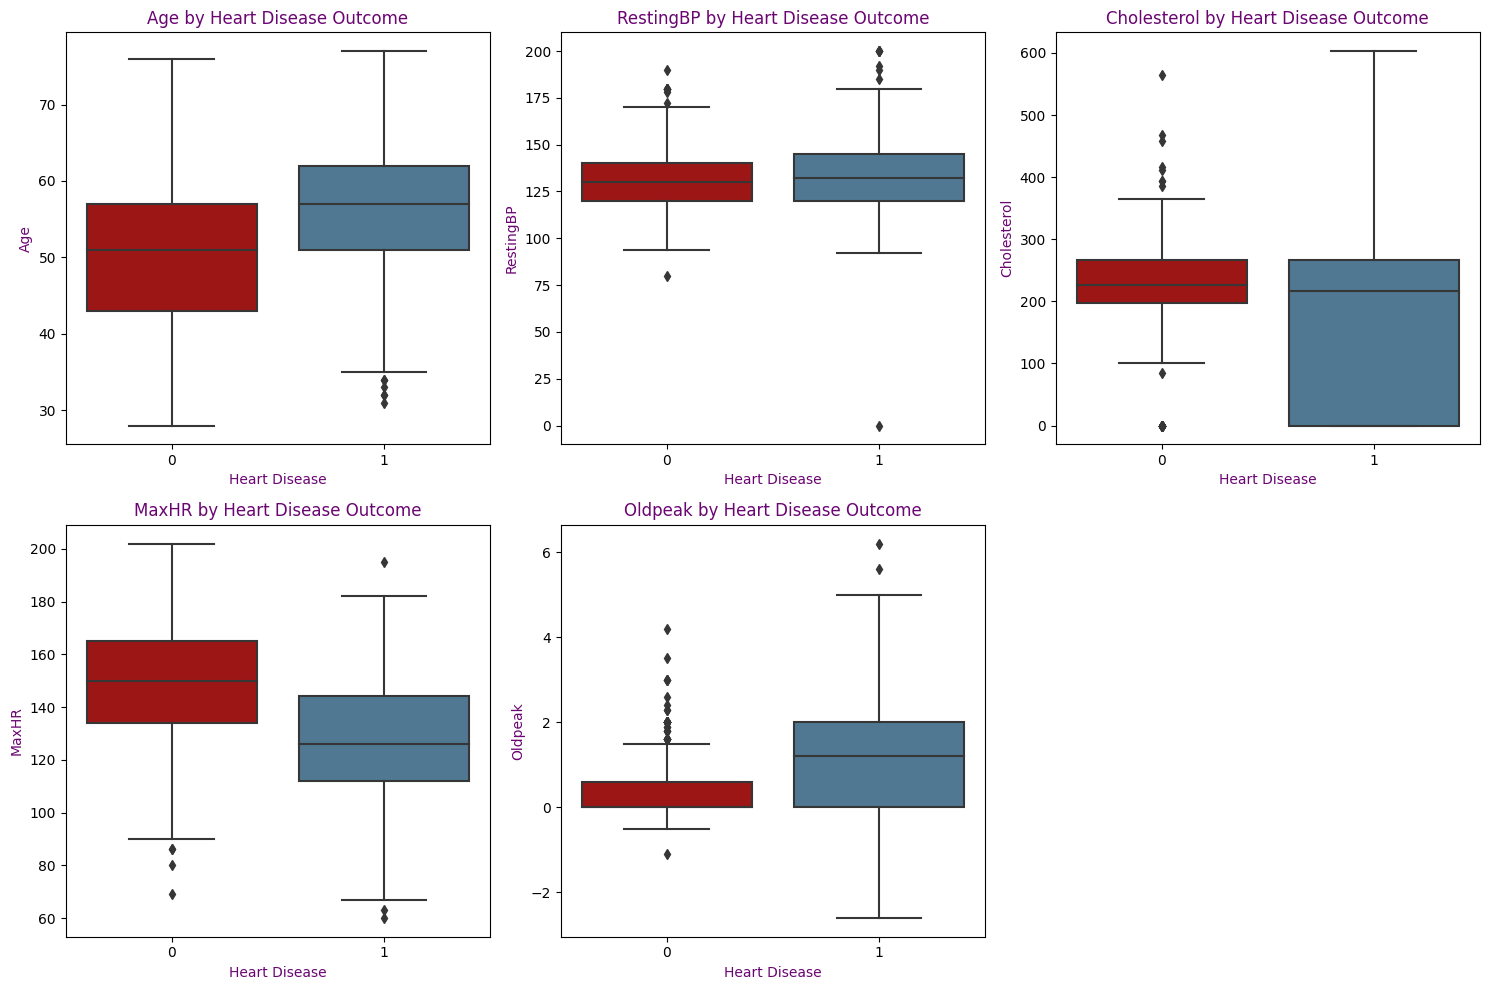

In [10]:
plt.figure(figsize=(15, 10))
features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
colors = ['#b30000', '#457b9d']
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=df, x='HeartDisease', y=feature, palette=colors)
    plt.title(f'{feature} by Heart Disease Outcome', color='#6a0572')
    plt.xlabel('Heart Disease', color='#6a0572')
    plt.ylabel(feature, color='#6a0572')
plt.tight_layout()
plt.show()


### Heatmap of Correlation Matrix

This heatmap shows the correlation coefficients between numerical features in the dataset. It helps to identify strong correlations between features, which can provide insights into potential predictors of heart disease.

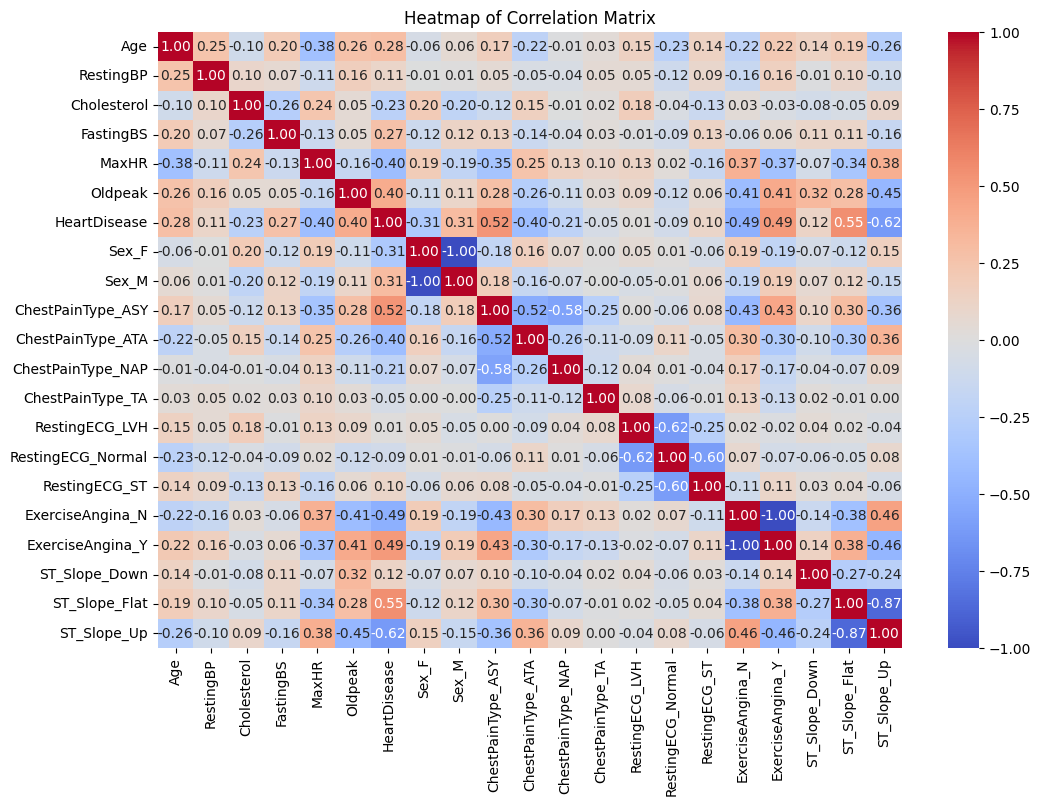

In [11]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Correlation Matrix')
plt.show()

### Stacked Bar Chart for Chest Pain Types by Heart Disease Outcome

This stacked bar chart shows the count of different chest pain types experienced by patients, split by the presence of heart disease. This helps to identify which types of chest pain are more prevalent among patients with and without heart disease.



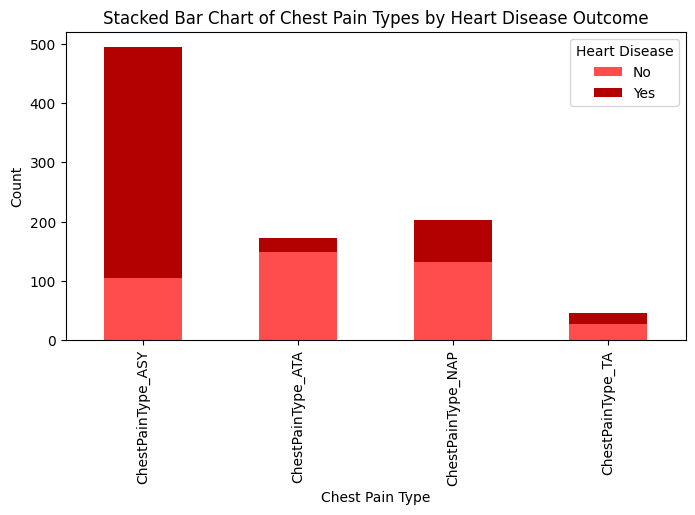

In [12]:
# Define heart-themed colors
heart_colors = ['#ff4d4d', '#b30000']  # Purple for Heart Disease No, Light Blue for Heart Disease Yes

# Chest pain types
chest_pain_types = ['ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA']

# Transpose the grouped data for plotting
heart_disease_outcome = df.groupby('HeartDisease')[chest_pain_types].sum().transpose()

# Plot
heart_disease_outcome.plot(kind='bar', stacked=True, figsize=(8, 4), color=heart_colors)
plt.title('Stacked Bar Chart of Chest Pain Types by Heart Disease Outcome')
plt.xlabel('Chest Pain Type')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['No', 'Yes'], loc='upper right')
plt.show()

### Scatter Plot for Age vs. MaxHR

This scatter plot shows the relationship between Age and MaxHR, with points colored by heart disease outcome. It helps to visualize any trends or correlations between age and maximum heart rate.



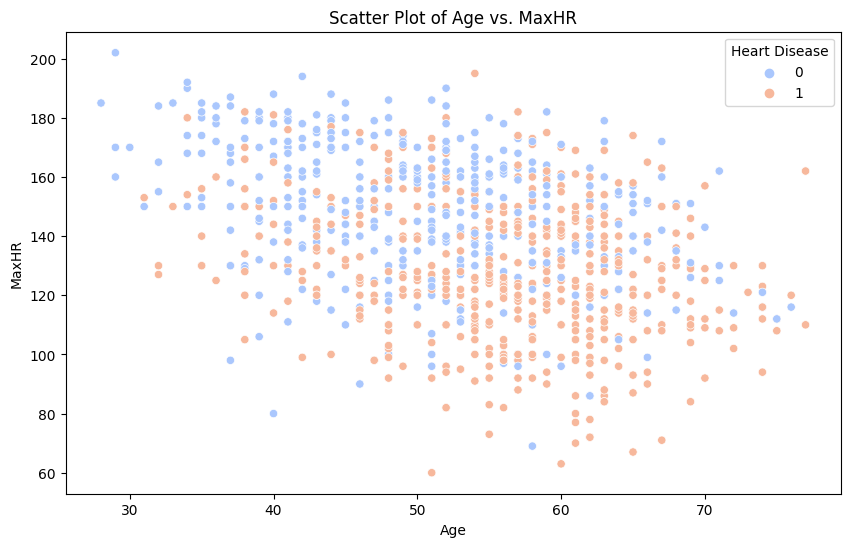

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='MaxHR', hue='HeartDisease', palette='coolwarm')
plt.title('Scatter Plot of Age vs. MaxHR')
plt.xlabel('Age')
plt.ylabel('MaxHR')
plt.legend(title='Heart Disease')
plt.show()

### Scatter Plot for RestingBP vs. Cholesterol

This scatter plot shows the relationship between RestingBP and Cholesterol, with points colored by heart disease outcome. It helps to identify any correlations or patterns between resting blood pressure and cholesterol levels.

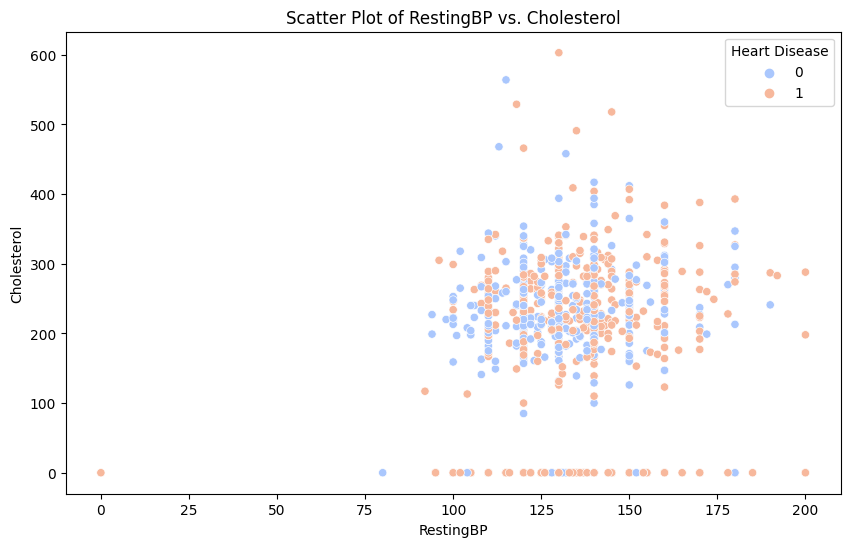

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='RestingBP', y='Cholesterol', hue='HeartDisease', palette='coolwarm')
plt.title('Scatter Plot of RestingBP vs. Cholesterol')
plt.xlabel('RestingBP')
plt.ylabel('Cholesterol')
plt.legend(title='Heart Disease')
plt.show()

# Step 3: Outlier Analysis

In [15]:
# Columns to analyze
columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Detect outliers for each column and count them
outliers_dict = {}
for column in columns:
    outliers = detect_outliers(df, column)
    outliers_dict[column] = outliers

# Summary of outliers in each column
for column in outliers_dict:
    print(f"{column}: {len(outliers_dict[column])}")

Age: 0
RestingBP: 28
Cholesterol: 183
MaxHR: 2
Oldpeak: 16


## Age:
Since there are no outliers detected for Age, there's no action needed regarding outliers for this particular feature.

## RestingBP (Resting Blood Pressure):
Having 28 outliers in RestingBP suggests that there are some extreme values that deviate significantly from the majority of data points. Consider the following actions:
- **Investigate the Nature of Outliers:** Determine if these outliers are due to data entry errors, measurement issues, or if they represent valid but extreme values.
- **Evaluate Impact:** Assess how these outliers might affect your analysis or models. For instance, if they skew the mean or other summary statistics significantly, their removal might be considered.

## Cholesterol:
With 183 outliers in Cholesterol, a similar approach applies:
- **Contextualize Outliers:** Understand if these values are plausible within the context of your dataset and the domain (e.g., extreme cholesterol levels due to specific health conditions).
- **Impact Assessment:** Evaluate how these outliers affect your analysis. Cholesterol levels can vary widely, but extreme values may still warrant closer inspection.

## MaxHR (Maximum Heart Rate):
Having only 2 outliers suggests that extreme values are rare but present. Consider:
- **Verification:** Check if these values are valid and if they represent exceptional cases that are important for your analysis.
- **Model Sensitivity:** Determine if these outliers affect model performance or the interpretation of results significantly.

## Oldpeak (ST Depression induced by exercise):
With 16 outliers in Oldpeak:
- **Significance Check:** Evaluate if these outliers are due to legitimate biological responses or if they could be errors.
- **Analysis Impact:** Consider whether these outliers affect the relationships or patterns you're exploring with Oldpeak and heart disease outcomes.


# Step 4: Spliting the dataset

In [16]:
# Select features and target variable
X = df[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
        'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
        'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST',
        'ExerciseAngina_N', 'ExerciseAngina_Y',
        'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']]
y = df['HeartDisease']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Fitting SVM (Support Vector Machine)

In [18]:
# Initialize and train the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [19]:
# Evaluate the model on test data
y_pred = svm_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8913


In [20]:
# Print classification report for more details
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87        77
           1       0.91      0.90      0.91       107

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



# Step 6: Fitting ANN (Aritifical Neural Network)

In [21]:
# Build the ANN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(32, activation='relu'),
    Dropout(0.3),  # Adding dropout for regularization
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [22]:
# Train the model
history = model.fit(X_train_scaled, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_test_scaled, y_test), 
                    callbacks=[early_stopping])

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5688 - loss: 0.7590 - val_accuracy: 0.7500 - val_loss: 0.5356
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7194 - loss: 0.5313 - val_accuracy: 0.8261 - val_loss: 0.4430
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7396 - loss: 0.5209 - val_accuracy: 0.8424 - val_loss: 0.3994
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8351 - loss: 0.3985 - val_accuracy: 0.8478 - val_loss: 0.3686
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8200 - loss: 0.4194 - val_accuracy: 0.8587 - val_loss: 0.3543
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8428 - loss: 0.3605 - val_accuracy: 0.8533 - val_loss: 0.3488
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8564 - loss: 0.3651 - val_accuracy: 0.8641 - val_loss: 0.3421
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8474 - loss: 0.3480 - val_accuracy: 0.8696 - 

In [23]:
# Save history into a df
df_ann_history = pd.DataFrame(history.history)

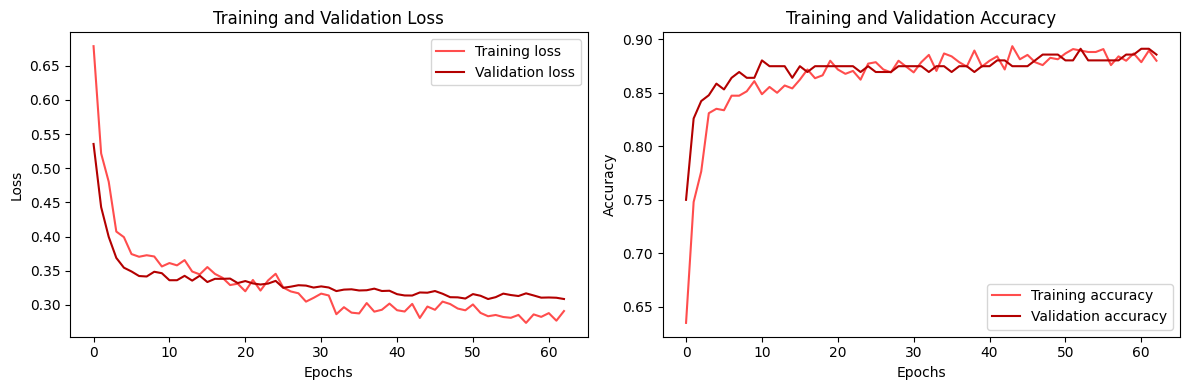

In [24]:
# Set heart-related colors
heart_colors = ['#ff4d4d', '#b30000']  # Red shades for loss and accuracy

# Plot both loss and accuracy in a single grid
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(df_ann_history['loss'], heart_colors[0], label='Training loss')
plt.plot(df_ann_history['val_loss'], heart_colors[1], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(df_ann_history['accuracy'], heart_colors[0], label='Training accuracy')
plt.plot(df_ann_history['val_accuracy'], heart_colors[1], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Step 7: Fitting CNN (Convolutional Neural Network)

In [25]:
# Reshape X_train_scaled and X_test_scaled for CNN input
X_train_cnn = np.expand_dims(X_train_scaled, axis=-1)
X_test_cnn = np.expand_dims(X_test_scaled, axis=-1)

In [26]:
# Build the CNN model
cnn_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [27]:
# Train the CNN model
cnn_history = cnn_model.fit(X_train_cnn, y_train,
                            epochs=100,
                            batch_size=32,
                            validation_data=(X_test_cnn, y_test),
                            callbacks=[early_stopping])

# Evaluate the CNN model on test data
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_test_cnn, y_test)

print(f'Test Accuracy (CNN): {test_accuracy_cnn:.4f}')
print(f'Test Loss (CNN): {test_loss_cnn:.4f}')

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4556 - loss: 0.7231 - val_accuracy: 0.7228 - val_loss: 0.6129
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6628 - loss: 0.6368 - val_accuracy: 0.8370 - val_loss: 0.5333
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7461 - loss: 0.5630 - val_accuracy: 0.8424 - val_loss: 0.4546
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7775 - loss: 0.5050 - val_accuracy: 0.8478 - val_loss: 0.4075
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7938 - loss: 0.4726 - val_accuracy: 0.8315 - val_loss: 0.3991
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7647 - loss: 0.4761 - val_accuracy: 0.8315 - val_loss: 0.3959
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7748 - loss: 0.4741 - val_accuracy: 0.8315 - val_loss: 0.3860
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7772 - loss: 0.4527 - val_accuracy: 0.8261 - 

In [28]:
# Save history into a df
df_cnn_history = pd.DataFrame(cnn_history.history)

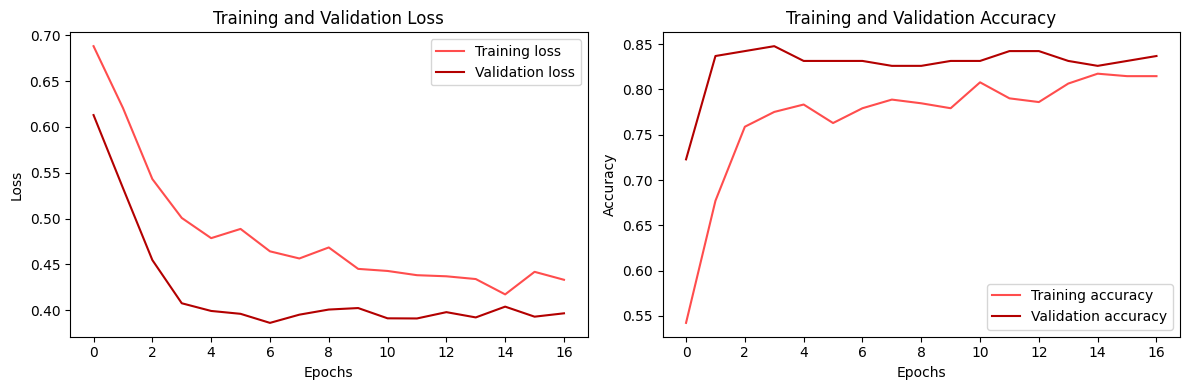

In [29]:
# Set heart-related colors
heart_colors = ['#ff4d4d', '#b30000']  # Red shades for loss and accuracy

# Plot both loss and accuracy in a single grid
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(df_cnn_history['loss'], heart_colors[0], label='Training loss')
plt.plot(df_cnn_history['val_loss'], heart_colors[1], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(df_cnn_history['accuracy'], heart_colors[0], label='Training accuracy')
plt.plot(df_cnn_history['val_accuracy'], heart_colors[1], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Conclusion

### Model Comparison for Heart Disease Prediction

#### Artificial Neural Network (ANN) Model:
- **Training Accuracy:** 90.03%
- **Training Loss:** 0.2767
- **Validation Accuracy:** 87.50%
- **Validation Loss:** 0.3231
- **Test Accuracy:** 88.04%
- **Test Loss:** 0.3048

#### Convolutional Neural Network (CNN) Model:
- **Training Accuracy:** 79.78%
- **Training Loss:** 0.4360
- **Validation Accuracy:** 83.15%
- **Validation Loss:** 0.3955
- **Test Accuracy (CNN):** 84.78%
- **Test Loss (CNN):** 0.3827

#### Support Vector Machine (SVM) Model:
- **Precision (No Heart Disease):** 0.86
- **Recall (No Heart Disease):** 0.88
- **F1-Score (No Heart Disease):** 0.87
- **Precision (Heart Disease):** 0.91
- **Recall (Heart Disease):** 0.90
- **F1-Score (Heart Disease):** 0.91
- **Overall Accuracy:** 89.00%

### Conclusion:
1. **Performance Comparison:**
   - The **ANN model** outperforms the **CNN model** in terms of accuracy and loss across the training, validation, and test datasets.
   - The **SVM model** performs comparably to the ANN model, achieving a slightly higher overall accuracy on the test set.

2. **Accuracy:**
   - **ANN**: 88.04%
   - **CNN**: 84.78%
   - **SVM**: 89.00%
   - SVM achieved the highest overall test accuracy, followed closely by the ANN.

3. **Loss:**
   - **ANN**: 0.3048
   - **CNN**: 0.3827
   - The ANN showed lower loss values compared to CNN, indicating better model performance.

4. **Model Suitability:**
   - Given the tabular nature of the data without spatial context, the ANN and SVM models are more suitable than the CNN model.
   - The ANN model captures complex interactions across features effectively for predicting heart disease outcomes.
   - The SVM model, with its high precision and recall, demonstrates strong classification performance.

5. **Recommendation:**
   - **ANN** is recommended for efficient and effective heart disease prediction due to its high accuracy and low loss.
   - **SVM** is also highly recommended, as it achieved the highest overall accuracy and demonstrated strong precision and recall.
   - **CNN** is less suited for this tabular dataset, showing lower performance compared to ANN and SVM.
